## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [67]:
%pip install requests pandas seaborn duckdb matplotlib.pyplot 

import os
import zipfile
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.


## Load data

In [68]:
import os
import zipfile


def unzip_if_needed(zip_path: str, extract_dir: str) -> None:
    """Unzip a ZIP file only if it hasn't been extracted yet."""
    if os.path.exists(extract_dir) and os.listdir(extract_dir):
        print(f"⚙️ Already unzipped — skipping extraction: {extract_dir}")
        return

    print(f"📦 Extracting {zip_path} ...")
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Files extracted to: {extract_dir}")



zip_path = "data/hra-pop-v1.0-qc.zip"
extract_dir = "data/unzipped"
unzip_if_needed(zip_path, extract_dir)

⚙️ Already unzipped — skipping extraction: data/unzipped


In [69]:
"""
D CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );
D .schema qc
CREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);
"""

"\nD CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );\nD .schema qc\nCREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);\n"

In [70]:
data_dir = "data/unzipped"

# 1. Create the table from JSON files
query = f"""
CREATE OR REPLACE TABLE qc AS
WITH qc_data AS (
    SELECT
        *,
        regexp_extract(filename, '.*/qc/([^/]+)/qc_results/.*', 1) AS folder_name
    FROM read_json('{data_dir}/qc/*/qc_results/qc_summary.json',
                   union_by_name = true,
                   filename = true)
),
datasets AS (
    SELECT
        regexp_extract(filename, '.*/qc/([^/]+)/dataset.json', 1) AS folder_name,
        dataset_id
    FROM read_json('{data_dir}/qc/*/dataset.json',
                   union_by_name = true,
                   filename = true)
)
SELECT 
    q.*,
    d.dataset_id
FROM qc_data q
LEFT JOIN datasets d USING (folder_name);
"""

# Run the query
duckdb.sql(query)

# ✅ Load the table into a Pandas DataFrame
df_qc = duckdb.sql("SELECT * FROM qc").df()

# 2. Export results to CSV
duckdb.sql(
    f"""
COPY qc TO '{data_dir}/cell-instances.csv.gz' (FORMAT CSV, HEADER, COMPRESSION GZIP);
"""
)

# 3. Optionally show a preview
print("\n🔍 Preview:")
duckdb.sql("SELECT * FROM qc LIMIT 10;").show()

# 4. Verify DataFrame content
print("\n📊 DataFrame loaded with shape:", df_qc.shape)
print(df_qc.head())


🔍 Preview:
┌────────────────────────────────────────────────────────────────┬─────────────┬───────────────────┬─────────────────────┬────────────────────┬──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────────────────────┐
│                           input_file                           │ total_cells │ low_quality_cells │ percent_low_quality │ mean_pct_counts_mt │ mean_pct_counts_ribo │                                                      thresholds                                                       │                                            files                                             │                               filename    

In [71]:
df_qc

,input_file,total_cells,low_quality_cells,percent_low_quality,mean_pct_counts_mt,mean_pct_counts_ribo,thresholds,files,filename,folder_name,dataset_id
0,/var/lib/cwl/stg32f34708-f7f0-45ad-91b5-563f92...,2324,0,0.00,0.0,0.001,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/GTEX-1CAMS-5015-SM-HPJ3C/qc_r...,GTEX-1CAMS-5015-SM-HPJ3C,https://doi.org/10.1126/science.abl4290#GTEX-1...
1,/var/lib/cwl/stg158c27e7-6bfd-4654-9939-62455a...,21563,7181,33.30,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM222.VQSW.335/qc_results/qc...,HBM222.VQSW.335,https://entity.api.hubmapconsortium.org/entiti...
2,/var/lib/cwl/stg7044a016-fbc3-4871-8aca-3d978b...,6000,10,0.17,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM237.TJFZ.599/qc_results/qc...,HBM237.TJFZ.599,https://entity.api.hubmapconsortium.org/entiti...
3,/var/lib/cwl/stga097e91c-36cb-4212-b587-9dc426...,3846,419,10.89,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM255.NWHK.947/qc_results/qc...,HBM255.NWHK.947,https://entity.api.hubmapconsortium.org/entiti...
4,/var/lib/cwl/stg09e7ab81-0747-4a52-b6ef-9b1a83...,8993,12,0.13,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM262.LMHQ.472/qc_results/qc...,HBM262.LMHQ.472,https://entity.api.hubmapconsortium.org/entiti...
...,...,...,...,...,...,...,...,...,...,...,...
553,/var/lib/cwl/stgcf74a0f3-fc5e-402d-830f-e5f857...,10522,0,0.00,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
554,/var/lib/cwl/stg2cbe4d56-b746-49ff-9267-e89976...,3441,0,0.00,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
555,/var/lib/cwl/stgb288659f-65e1-4554-b1b9-cd37b8...,1960,1,0.05,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
556,/var/lib/cwl/stg79722db5-3418-4cdb-a7ca-46bd3b...,3579,293,8.19,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...


## Preprocess before visualizing

In [72]:
# Load Sankey CSV to add organ name
df_sankey = pd.read_csv(
    "https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/main/output-data/v1.0/reports/universe-ad-hoc/sankey.csv"
)[["organ_name", "dataset_id"]]

df_sankey

/var/folders/x7/ttglg94d4g500ypbdkw3__nw0000gq/T/ipykernel_53329/2169947450.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sankey = pd.read_csv(


,organ_name,dataset_id
0,small intestine,hhttps://api.cellxgene.cziscience.com/dp/v1/co...
1,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...
2,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...
3,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...
4,mesenteric lymph node,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...
...,...,...
22189,heart,https://sparc.science/datasets/390/version/1?d...
22190,heart,https://sparc.science/datasets/390/version/1?d...
22191,heart,https://sparc.science/datasets/390/version/1?d...
22192,left kidney,https://zenodo.org/records/7653239#Donor1_Tiss...


In [73]:
df_merged = df_qc.merge(df_sankey, on="dataset_id", how="inner")

## Visualize

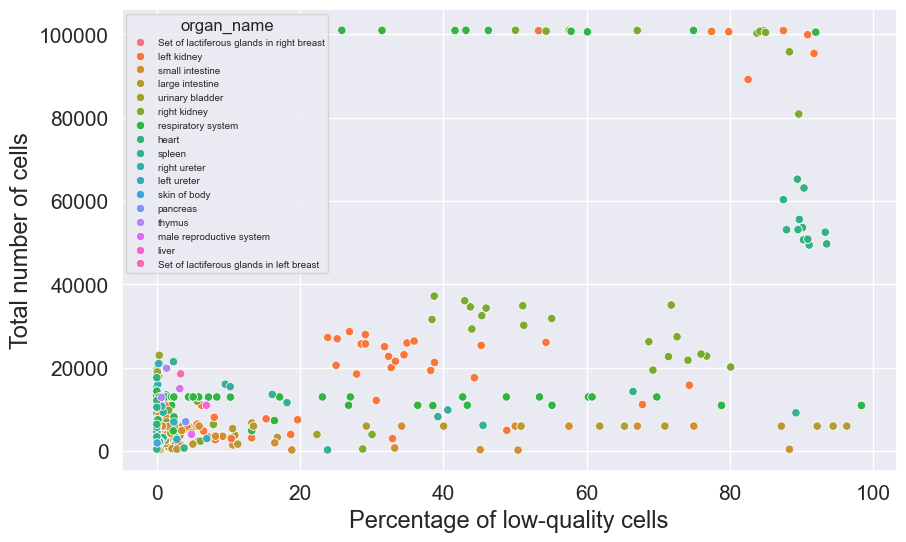

In [75]:
# Set theme
sns.set_theme(
    # context="talk",  # adjusts scale of fonts and elements ('paper', 'notebook', 'talk', 'poster')
    # style="whitegrid",
    rc={
        "figure.figsize": (10, 6),  # global figure size
        "font.size": 15,  # base font size
        "axes.titlesize": 119,  # title font size
        "axes.labelsize": 17,  # axis label font size
        "xtick.labelsize": 15,  # x tick label size
        "ytick.labelsize": 15,  # y tick label size
        "legend.fontsize": 7,  # legend font size
    },
)

sns.scatterplot(
  data=df_merged,
  x="percent_low_quality",
  y="total_cells",
  hue="organ_name"
)

# Label the x-axis
plt.xlabel("Percentage of low-quality cells")
plt.ylabel("Total number of cells")
plt.title("")

plt.show()